# Objective

I want to see how well managers performed at Bayern in the last few years, as there has been a lot of turnover. To do so, I want to scrape match results from the last few seasons from FBREF, and calculate maybe points/game for each month and see how this fluctuates.

---

# Import libraries

In [1]:
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

import pandas as pd

from io import StringIO

import matplotlib.pyplot as plt
import seaborn as sns

---

# Obtaining Match Data from FBREF

`Selenium` will be used to obtain data from FBREF, specifically from pages like this for each season: 

https://fbref.com/en/squads/054efa67/2023-2024/matchlogs/all_comps/schedule/Bayern-Munich-Scores-and-Fixtures-All-Competitions

The first table on that page will be scraped, before clicking the "<<Previous Season" button and repeating for the previous season. This will be done for the previous 10 seasons.

In [2]:
# Initialise final data frame:
df = pd.DataFrame()

# Use driver to open the first page in a browser:
driver = webdriver.Chrome()
driver.get("https://fbref.com/en/squads/054efa67/Bayern-Munich-Stats")

# Iterate for last 10 seasons:
for i in range(10):
# Close the cookies popup for the first iteration:
    if i == 0:
        cookies_button_appears = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, "/html/body/div[1]/div/div/div/div[2]/div/button[2]")))
        decline_cookies_button = driver.find_element(by=By.XPATH, value="/html/body/div[1]/div/div/div/div[2]/div/button[2]")
        decline_cookies_button.click()
# On the fifth iteration, another popup appears:
    elif i == 5:
        popup_appears = WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="modal-container"]')))
        popup_x = driver.find_element(By.XPATH, '//*[@id="modal-close"]')
        popup_x.click()
# If not the first iteration, need to click the "Previous Season" button before scraping:
    else:
        previous_season_button = driver.find_element(by=By.XPATH, value='//*[@id="meta"]/div[2]/div/a[1]')
        previous_season_button.click()

# Scrape data and add to df:
    seasons_table = driver.find_element(by=By.XPATH, value='//*[@id="matchlogs_for"]').get_attribute('outerHTML')
    df = pd.concat([df, pd.read_html(StringIO(seasons_table))[0]])

# Remove rows including column heading, and sort by date:
df = df[df["Notes"] != "Notes"]
df["Date"] = pd.to_datetime(df["Date"])
df = df.sort_values("Date").reset_index(drop=True)

# Close browser:
driver.close()

View final data frame summaries:

In [3]:
df.head()

,Date,Time,Comp,Round,Day,Venue,Result,GF,GA,Opponent,xG,xGA,Poss,Attendance,Captain,Formation,Referee,Match Report,Notes
0,2015-08-01,20:30 (19:30),DFL-Supercup,DFL-Supercup,Sat,Away,D,1 (4),1 (5),Wolfsburg,NaN,NaN,55,30000,Philipp Lahm,4-1-4-1,Marco Fritz,Match Report,NaN
1,2015-08-09,16:00 (15:00),DFB-Pokal,First round,Sun,Away,W,3,1,Nöttingen,NaN,NaN,NaN,29486,Philipp Lahm,3-4-3,Robert Kampka,Match Report,NaN
2,2015-08-14,20:30 (19:30),Bundesliga,Matchweek 1,Fri,Home,W,5,0,Hamburger SV,NaN,NaN,77,75000,Philipp Lahm,4-1-4-1,Bastian Dankert,Match Report,NaN
3,2015-08-22,15:30 (14:30),Bundesliga,Matchweek 2,Sat,Away,W,2,1,Hoffenheim,NaN,NaN,73,30150,Philipp Lahm,3-4-3◆,Tobias Stieler,Match Report,NaN
4,2015-08-29,18:30 (17:30),Bundesliga,Matchweek 3,Sat,Home,W,3,0,Leverkusen,NaN,NaN,66,75000,Philipp Lahm,3-4-3◆,Florian Meyer,Match Report,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 498 entries, 0 to 497
Data columns (total 19 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   Date          498 non-null    datetime64[ns]
 1   Time          491 non-null    object        
 2   Comp          498 non-null    object        
 3   Round         498 non-null    object        
 4   Day           498 non-null    object        
 5   Venue         498 non-null    object        
 6   Result        483 non-null    object        
 7   GF            483 non-null    object        
 8   GA            483 non-null    object        
 9   Opponent      498 non-null    object        
 10  xG            337 non-null    object        
 11  xGA           337 non-null    object        
 12  Poss          475 non-null    object        
 13  Attendance    403 non-null    object        
 14  Captain       483 non-null    object        
 15  Formation     483 non-null    object    

---

# Performance Analysis

As an initial analysis, we look at just Bundesliga fixtures, and calculate 10-match rolling points averages. We also add dates that new managers came in, looking at the period from Niko Kovac onwards.

In [5]:
# Add numeric column for points from result:
df["Points"] = df["Result"].map({"W":3, "D":1, "L":0})

# Create a data frame with 10-match rolling points average and date of match:
df_plot = pd.DataFrame({
    "Date": df[df["Comp"] == "Bundesliga"]["Date"],
    "Points": df[df["Comp"] == "Bundesliga"]["Points"].rolling(window=10).mean()
}).dropna().reset_index(drop=True)

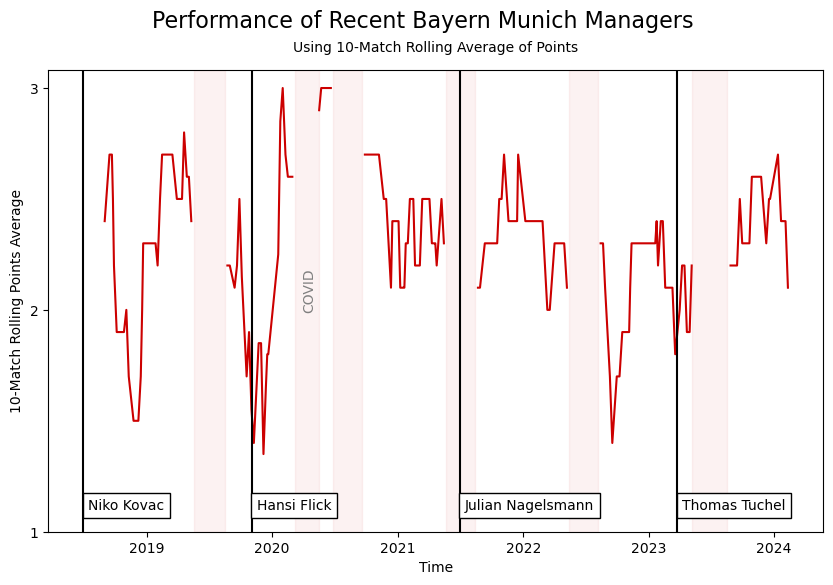

In [6]:
managers = {
    "Thomas Tuchel": "2023-03-25",
    "Julian Nagelsmann": "2021-07-01",
    "Hansi Flick": "2019-11-03",
    "Niko Kovac": "2018-07-01"
}

seasons = {
    "2018/19": ["2018-08-24", "2019-05-18"],
    "2019/20 pre-covid": ["2019-08-16", "2020-03-08"],
    "2019/20 post-covid": ["2020-05-16", "2020-06-27"],
    "2020/21": ["2020-09-18", "2021-05-22"],
    "2021/22": ["2021-08-13", "2022-05-14"],
    "2022/23": ["2022-08-05", "2023-05-07"],
    "2023/24": ["2023-08-18", "2024-02-14"]
}

breaks = {
    "2023 off-season": ["2023-05-07", "2023-08-18"],
    "2022 off-season": ["2022-05-14", "2022-08-05"],
    "2021 off-season": ["2021-05-22", "2021-08-13"],
    "2020 off-season": ["2020-06-27", "2020-09-18"],
    "COVID": ["2020-03-08", "2020-05-16"],
    "2019 off-season": ["2019-05-18", "2019-08-16"]
}

# Plot results, with key dates added:
f,a = plt.subplots(figsize=(10,6))

for name, date in seasons.items():
    season = df_plot[(df_plot["Date"] > pd.to_datetime(date[0])) & (df_plot["Date"] < pd.to_datetime(date[1]))]
    sns.lineplot(season, x="Date", y="Points", color="#CC0000", ax=a, err_style=None)

for name, date in managers.items():
    plt.axvline(x=pd.to_datetime(date), color="black")
    plt.text(x=pd.to_datetime(date) + pd.to_timedelta(14, unit="days"), y=1.1, s=name, bbox={"facecolor":'white', "edgecolor":'black'})

for reason, date in breaks.items():
    plt.axvspan(xmin=pd.to_datetime(date[0]), xmax=pd.to_datetime(date[1]), alpha=0.05, color="#CC0000")
    if reason == "COVID":
        plt.text(x=pd.to_datetime(date[0]) + pd.to_timedelta(21, unit="days"), y=2, s=reason, rotation=90, zorder=2, color="gray")
    
plt.yticks([1,2,3])
plt.ylabel("10-Match Rolling Points Average")
plt.xlabel("Time")
plt.suptitle("Performance of Recent Bayern Munich Managers", fontsize=16)
plt.title("Using 10-Match Rolling Average of Points", fontsize=10, y=1.02)
    
plt.show()